In [1]:
# Use Plots:
using Plots
#using PhotoStructs
pyplot()

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1260


Plots.PyPlotBackend()

In [2]:
using Revise
using Land
using BenchmarkTools
using Statistics
using Parameters

In [3]:
@unpack CanopyRTMod = Land
@unpack FT, leafbio, canopy, angles, canOpt, canRad,sunRad,soil = Land.CanopyRTMod

Land.CanopyRTMod

In [4]:
wl = CanopyRTMod.wl;
wle = CanopyRTMod.wle;
wlf = CanopyRTMod.wlf;

In [5]:
#@time CanopyRTMod.optis.nr[3:20] .= 2

In [6]:
leaf = leafbio{FT, length(wl), length(wle), length(wlf),length(wle)*length(wlf)}();


In [7]:
using Parameters
@unpack N, Cab, Car, Ant, Cs, Cw, Cm, ρ_SW, τ_SW = CanopyRTMod.leaf;

In [9]:
@time CanopyRTMod.fluspect!(CanopyRTMod.leaf, CanopyRTMod.optis);

  0.000967 seconds (2.99 k allocations: 995.047 KiB)


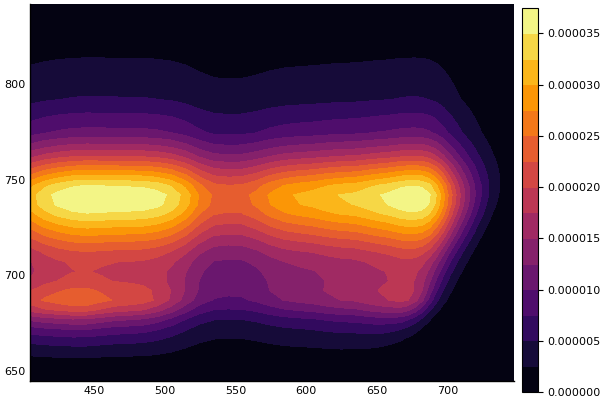

In [10]:
contourf(wle, wlf, CanopyRTMod.leaf.Mb)

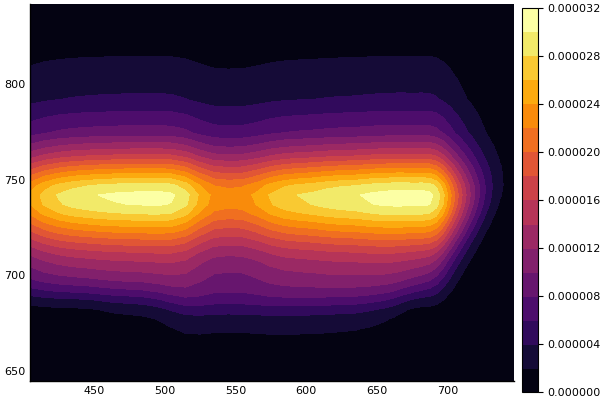

In [11]:
contourf(wle, wlf, CanopyRTMod.leaf.Mf)

In [12]:
arrayOfLeaves = Array{leafbio{FT,length(wl), length(wle), length(wlf),length(wle)*length(wlf)}, 1}(undef, CanopyRTMod.canopy.nlayers)
for i = 1:CanopyRTMod.canopy.nlayers
    #@show i
    arrayOfLeaves[i] = leafbio{FT, length(wl), length(wle), length(wlf),length(wle)*length(wlf)}()
    CanopyRTMod.fluspect!(arrayOfLeaves[i], CanopyRTMod.optis)
end

In [21]:
CanopyRTMod.angles.tto=-88
CanopyRTMod.angles.psi=50
@time CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt);
@time CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);
@time CanopyRTMod.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil);
CanOpt2 = deepcopy(canOpt)
@time CanopyRTMod.computeSIF_Fluxes!(arrayOfLeaves, canOpt, canRad, canopy, CanopyRTMod.soil);

  0.000213 seconds (1.34 k allocations: 58.000 KiB)
  0.000028 seconds
  0.000186 seconds (483 allocations: 304.047 KiB)
  0.001095 seconds (3.18 k allocations: 1.899 MiB)


In [22]:
# Set Soil albedo to 0.2
CanopyRTMod.soil.albedo_SW[:] .=0.2;

### Test a VZA dependence in the principal plane

In [27]:
reflVIS = []
reflNIR = []
SIF_FR = []
SIF_FR1 = []
SIF_FR2 = []
SIF_FR3 = []
SIF_FR4 = []
SIF_R1 = []
SIF_R2 = []
SIF_R3 = []
SIF_R4 = []
SIF_R  = []
Pso = []
Po = []
Ps = []
ko = []
CanopyRTMod.angles.tts=30
CanopyRTMod.angles.psi=0
CanopyRTMod.canopy.LAI = 3
# Define VZA 
VZA=collect(-89.5:0.5:89.5)

for VZA_ in VZA
    CanopyRTMod.angles.tto=VZA_
    CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt);
    CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);
    CanopyRTMod.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil);
    CanopyRTMod.computeSIF_Fluxes!(arrayOfLeaves, canOpt, canRad, canopy, CanopyRTMod.soil);
    push!(reflVIS, canRad.alb_obs[28])
    push!(reflNIR, canRad.alb_obs[52])
    push!(SIF_R , canRad.SIF_obs[8])
    push!(SIF_FR, canRad.SIF_obs[20])
    push!(SIF_FR1, canRad.SIF_obs_sunlit[20])
    push!(SIF_FR2, canRad.SIF_obs_scattered[20])
    push!(SIF_FR3, canRad.SIF_obs_soil[20])
    push!(SIF_FR4, canRad.SIF_obs_shaded[20])
    push!(SIF_R1, canRad.SIF_obs_sunlit[8])
    push!(SIF_R2, canRad.SIF_obs_scattered[8])
    push!(SIF_R3, canRad.SIF_obs_soil[8])
    push!(SIF_R4, canRad.SIF_obs_shaded[8])
    push!(Pso, canOpt.Pso[1])
    push!(Ps, canOpt.Ps[1])
    push!(Po, canOpt.Po[1])
    push!(ko, canOpt.ko[1])
end


### Plot total hemispheric outgoing SIF (and sum of all layer SIF emissions)

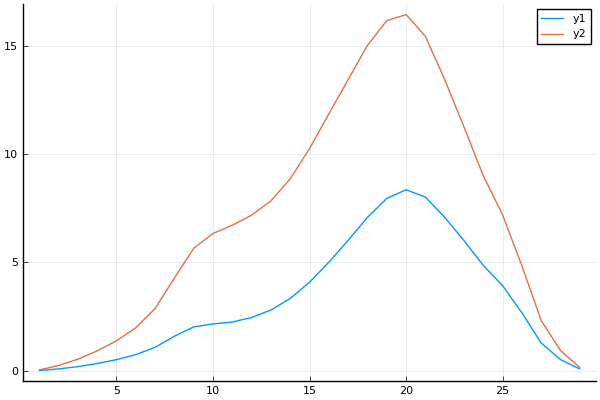

In [28]:
CanopyRTMod.angles.tto=89
CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt);
CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);
CanopyRTMod.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil);
CanopyRTMod.computeSIF_Fluxes!(arrayOfLeaves, canOpt, canRad, canopy, CanopyRTMod.soil);
plot(canRad.SIF_hemi)
plot!(canRad.SIF_sum)

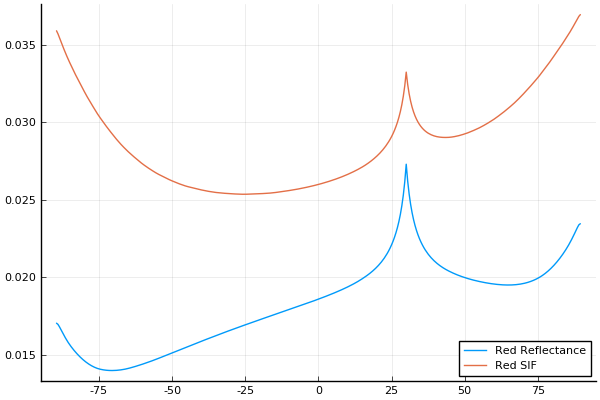

In [30]:

plot(VZA, reflVIS, label="Red Reflectance")
plot!(VZA, SIF_FR/100, label="Red SIF")

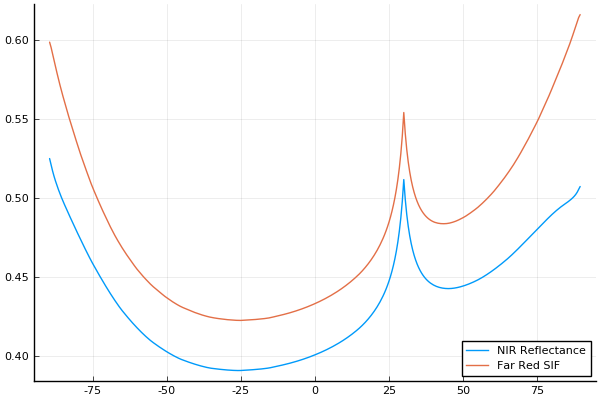

In [34]:
plot(VZA, reflNIR, label="NIR Reflectance")
plot!(VZA, SIF_FR/6, label="Far Red SIF")

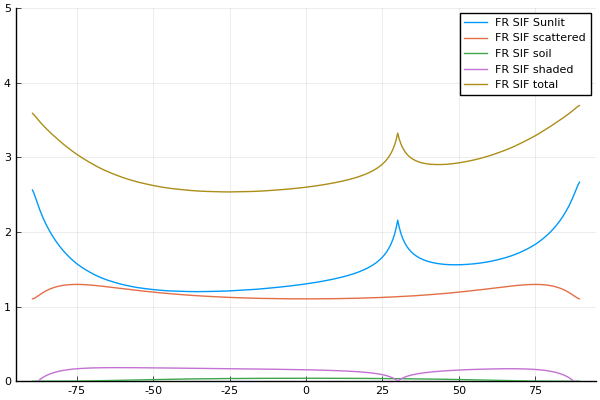

In [35]:
plot(VZA, SIF_FR1, label="FR SIF Sunlit")
plot!(VZA, SIF_FR2, label="FR SIF scattered")
plot!(VZA, SIF_FR3, label="FR SIF soil")
plot!(VZA, SIF_FR4, label="FR SIF shaded")
plot!(VZA, SIF_FR, label="FR SIF total")
ylims!(0,5)

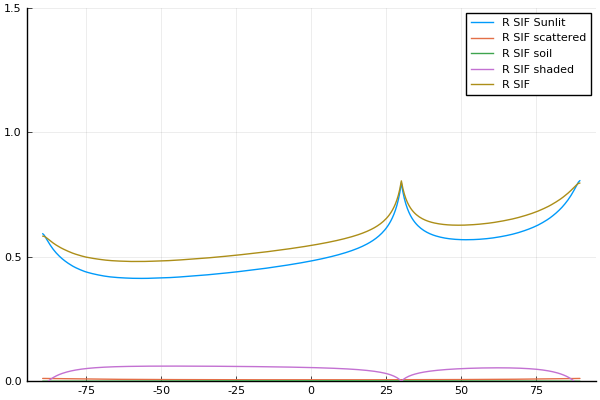

In [37]:
plot(VZA, SIF_R1, label="R SIF Sunlit")
plot!(VZA, SIF_R2, label="R SIF scattered")
plot!(VZA, SIF_R3, label="R SIF soil")
plot!(VZA, SIF_R4, label="R SIF shaded")
plot!(VZA, SIF_R, label="R SIF ")
ylims!(0,1.5)

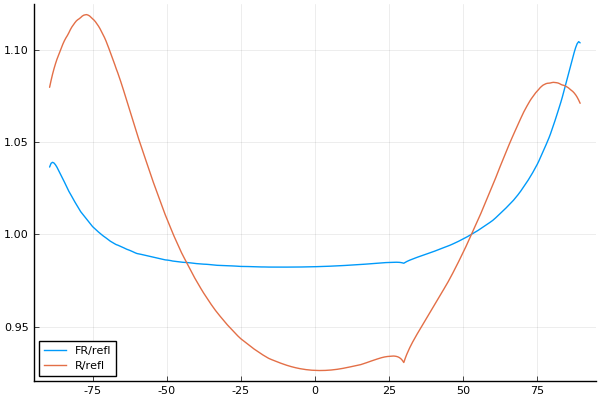

In [38]:
plot(VZA, SIF_FR./reflNIR./mean(SIF_FR./reflNIR), label="FR/refl")
plot!(VZA, SIF_R./reflVIS./mean(SIF_R./reflVIS), label="R/refl")
#plot!(VZA, , label="Far Red SIF")

In [39]:
CanopyRTMod.soil.albedo_SW[:] .=0.2;
reflRed_SZA = []
reflNIR_SZA = []
CanopyRTMod.canopy.Ω = 1.0
CanopyRTMod.angles.tto=0.2
CanopyRTMod.canopy.LAI=2.
for SZA=0.0:1:75
    CanopyRTMod.angles.tts=SZA
    CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt);
    CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);
    CanopyRTMod.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil);
    push!(reflRed_SZA, canRad.alb_direct[28])
    push!(reflNIR_SZA, canRad.alb_direct[52])
end

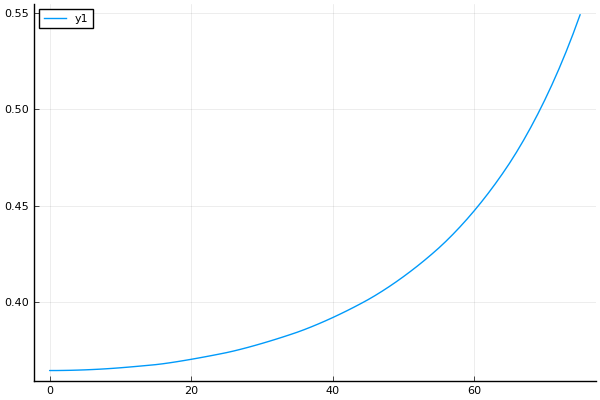

In [40]:
SZA=0:1:75
plot(SZA, reflNIR_SZA)

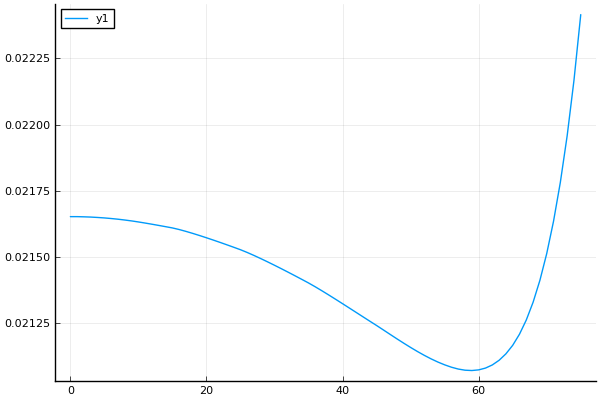

In [41]:
SZA=0:1:75
plot(SZA, reflRed_SZA)

In [103]:
# Test plots from Christiaan's papers

In [42]:
reflVIS = Float32[]
reflNIR = Float32[]
SIF_FR = Float32[]
SIF_R  = Float32[]
CanopyRTMod.angles.tts=48
CanopyRTMod.angles.psi=0
CanopyRTMod.canopy.LAI=3.22
for psi=0:360
    CanopyRTMod.angles.psi=psi
    for VZA=0:1:85
        CanopyRTMod.angles.tto=VZA

        CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt);
        CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);
        CanopyRTMod.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil);
        CanopyRTMod.computeSIF_Fluxes!(arrayOfLeaves, canOpt, canRad, canopy, CanopyRTMod.soil);
        push!(reflVIS, canRad.alb_obs[28])
        push!(reflNIR, canRad.alb_obs[52])
        push!(SIF_R , canRad.SIF_obs[8])
        push!(SIF_FR, canRad.SIF_obs[20])
    end
end

In [43]:
A = reshape(reflNIR, ( 86,361));
B = reshape(reflVIS, ( 86,361));
SIFFER = reshape(SIF_R, ( 86,361));
SIFFER_FR = reshape(SIF_FR, ( 86,361));

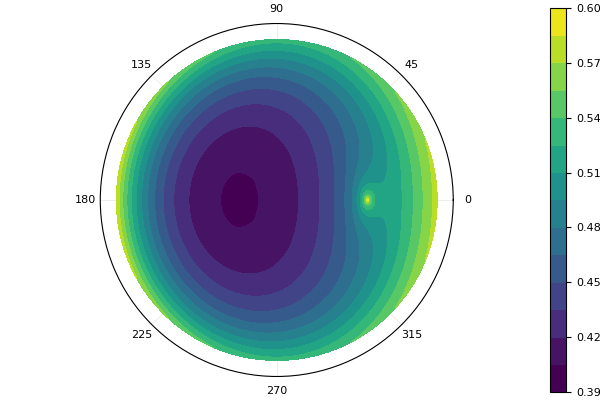

In [44]:
using Plots; pyplot()

#heatmap(A, cmap=)
hm = contourf(deg2rad.(collect((0:360))),collect(0:1:85),  A,  proj=:polar, color=:viridis, alpha=0.5)

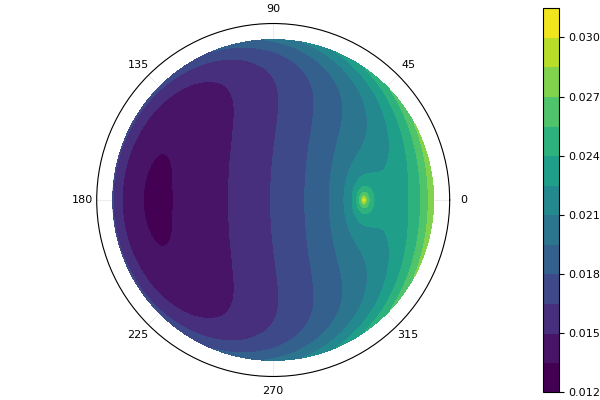

In [45]:
#heatmap(A, cmap=)
hm = contourf(deg2rad.(collect((0:360))),collect(0:1:85),  B,  proj=:polar, color=:viridis)

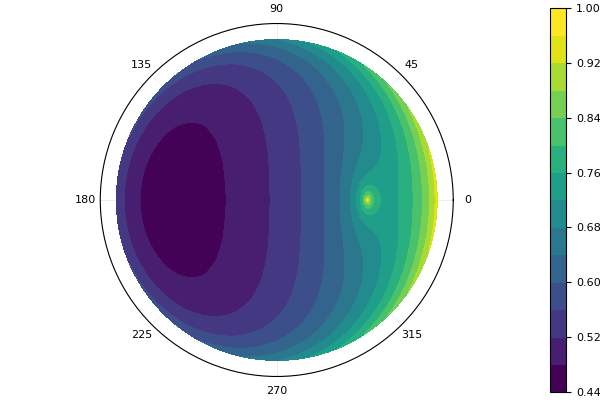

In [46]:
hm = contourf(deg2rad.(collect((0:360))),collect(0:1:85),  SIFFER, proj=:polar, color=:viridis)

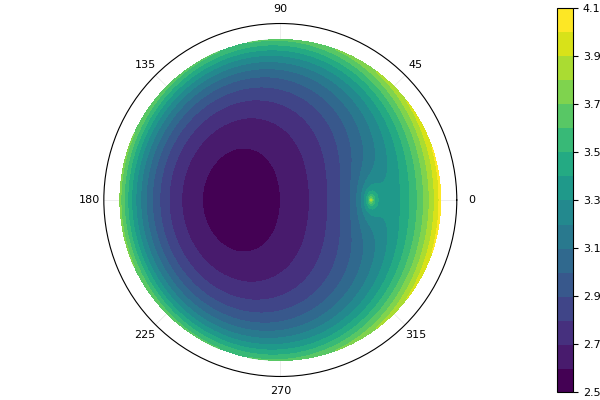

In [47]:
hm = contourf(deg2rad.(collect((0:360))),collect(0:1:85),  SIFFER_FR, proj=:polar, color=:viridis)